<left><img width=100% height=100% src="img/itu_logo.png"></left>

## Lecture 08: Classification Algorithms, K-Nearest Neighbors (K-NN) Algorithm

### __Gül İnan__<br><br>Istanbul Technical University

<br>
<br>

# Classification

So far, every supervised learning algorithm that we've seen has been an instance of regression problem.

Next, let's look at some classification algorithms. First, we will define what classification is.

## Review: Components of a Supervised Machine Learning Problem

At a high level, a supervised machine learning problem has the following structure:

$$ 
\underbrace{\text{Training Dataset}}_\text{Target + Features} + \underbrace{\text{Learning Algorithm}}_\text{Model Class + Objective + Optimizer } \to \text{Predictive Model} 
$$

## Regression vs. Classification

Consider a training dataset $\mathcal{D} = \{(\mathbf{x}_{1}, y_{1}), (\mathbf{x}_{2}, y_{2}), \ldots, (\mathbf{x}_{n}, y_{n})\}$.

We distinguish between `two types of supervised learning problems` depending on the targets $y_{i}$. 

1. `Regression`: The target variable $y_i \in \mathcal{Y}$ is `continuous`:  $\mathcal{Y} \subseteq \mathbb{R}$.
2. `Classification`: The target variable $y_i$ is `discrete` and takes on one of $K$ possible values:  $\mathcal{Y} = \{c_1,\ldots, c_l, \ldots, c_K\}$ and `each discrete value` corresponds to a `class` that we want to predict. 

### Classification Examples

- Disease diagnoses: Classifying whether a patient is healthy or not.
- Text classification: Classifying documents according to topic.

## Binary Classification

An important special case of classification is when the number of classes $K=2$ and $y_i \in \{0,1\}$.

In this case, we have an instance of a `binary classification` problem.

## Diabetes Dataset

The diabetes data, which is collected by [National Institute of Diabetes and Digestive and Kidney Diseases](https://www.niddk.nih.gov/), consists of demographic and clinical information about 768 patients, where 268 of them have been tested positive for diabetes. 

In the data set:

  - `Diabetic` column contains the value **0** for patients who tested **negative for diabetes**, and **1** for patients who **tested positive**.
  - `Pregnancies`, `PlasmaGlucose`, `DiastolicBloodPressure`, `TricepsThickness`, `SerumInsulin`, `BMI`, `DiabetesPedigree` and `Age` are the **features** that can be used to predict the `Diabetic` label of the patients.

In [547]:
#import the data set

import pandas as pd

diabetes_df = pd.read_csv("datasets/Diabetes.csv")

In [548]:
diabetes_df.head()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [549]:
diabetes_df.shape

(768, 9)

In [550]:
#check the number of 0's and 1's in the data set. 
diabetes_df.diabetes.value_counts()

0    500
1    268
Name: diabetes, dtype: int64

In [551]:
#there are some inconsistent values in the data set. I removed patients whose bmi and glucose are both zero
diabetes_df = diabetes_df[(diabetes_df.bmi!=0) & (diabetes_df.glucose!=0)]

In [552]:
diabetes_df.shape

(752, 9)

Let's visualize our Diabetes dataset based on the first two features `bmi` and `glucose` with respect to `diabetes` status of the patients.

In [553]:
#Prepare X and y
X = diabetes_df[["bmi","glucose"]]
y = diabetes_df[["diabetes"]]

To keep the `class balance` (ratio of 0's to 1's) both in training and test data, we should set `stratify=y` in [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [554]:
#first split the data as train and test. Use stratify so that the ratio of 0's to 1's in train data equals to that of in test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1773, stratify=y)

In [555]:
y_train.value_counts()

diabetes
0           390
1           211
dtype: int64

In [556]:
#check
print("Ratio of 0's to 1's in the training set: %.4f" % (y_train.value_counts()[0]/y_train.value_counts()[1]))

Ratio of 0's to 1's in the training set: 1.8483


In [557]:
y_test.value_counts()

diabetes
0           98
1           53
dtype: int64

In [558]:
#check
print("Ratio of 0's to 1's in the test set: %.4f" % (y_test.value_counts()[0]/y_test.value_counts()[1]))

Ratio of 0's to 1's in the test set: 1.8491


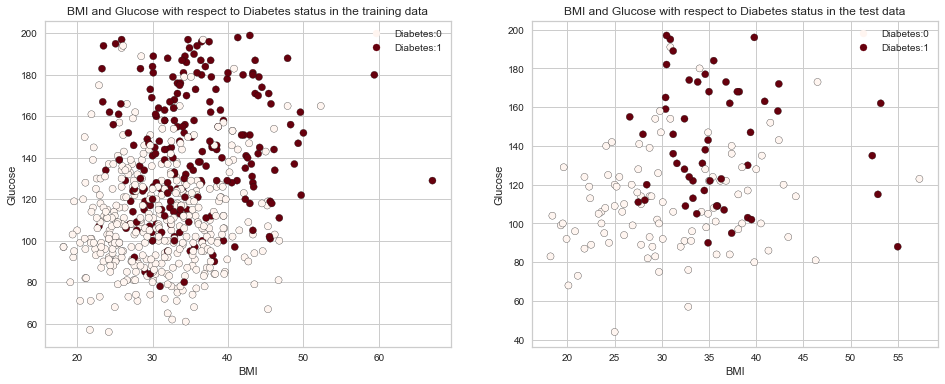

In [559]:
#visualize the train and test data
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 6]

fig, (ax1, ax2) = plt.subplots(1, 2)

#left plot
p1 = ax1.scatter(X_train.bmi, X_train.glucose, c=y_train.diabetes, edgecolor='k', s=50, cmap="Reds")            
ax1.set_xlabel('BMI')
ax1.set_ylabel('Glucose')
ax1.set_title('BMI and Glucose with respect to Diabetes status in the training data')
ax1.legend(handles=p1.legend_elements()[0], labels=['Diabetes:0', 'Diabetes:1'], loc='upper right')

#right plot
p2 = ax2.scatter(X_test.bmi, X_test.glucose, c=y_test.diabetes, edgecolor='k', s=50, cmap="Reds")            
ax2.set_xlabel('BMI')
ax2.set_ylabel('Glucose')
ax2.set_title('BMI and Glucose with respect to Diabetes status in the test data')
ax2.legend(handles=p2.legend_elements()[0], labels=['Diabetes:0', 'Diabetes:1'], loc='upper right')

plt.show();

We can see that patients whose BMI and Glucose levels are high are more likely to develop diabetes.

## Understanding Classification

How is clasification different from regression?
* In **regression**, we try to **fit a curve** through the set of targets $y_{i}$.
* In **classification**, classes define a **partition of the feature space**, and our goal is to find the **boundaries that separate these regions**.
* Outputs of classification models have a simple probabilistic interpretation: they are probabilities that a data point belongs to a given class.

Let's train a classification algorithm on this data.

Below, we see the regions predicted to be associated with the two classes and the line between them in the decision boundary.

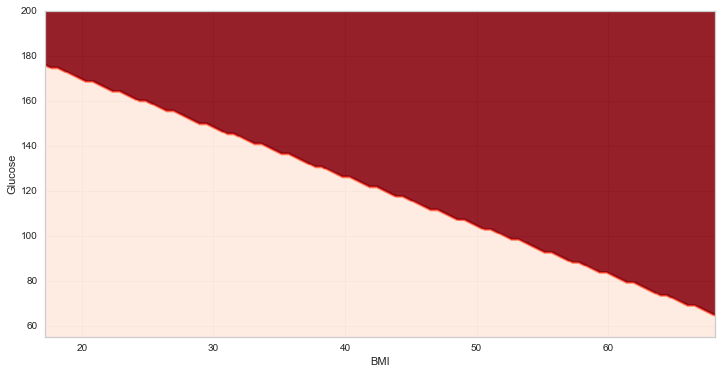

In [560]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression

#we will learn logistic regression next week
logreg = LogisticRegression(C=1e5)
logreg.fit(X_train, y_train.diabetes)

#learn the decision boundary (the equation of the line separating the feature space) from training data
db = DecisionBoundaryDisplay.from_estimator(estimator=logreg, X=X_train, response_method="predict", 
                                            xlabel="BMI", ylabel="Glucose", cmap="Reds", 
                                            alpha=0.9)                                            
plt.show();
#red region refers to diabetes, light region refers to non-diabetes

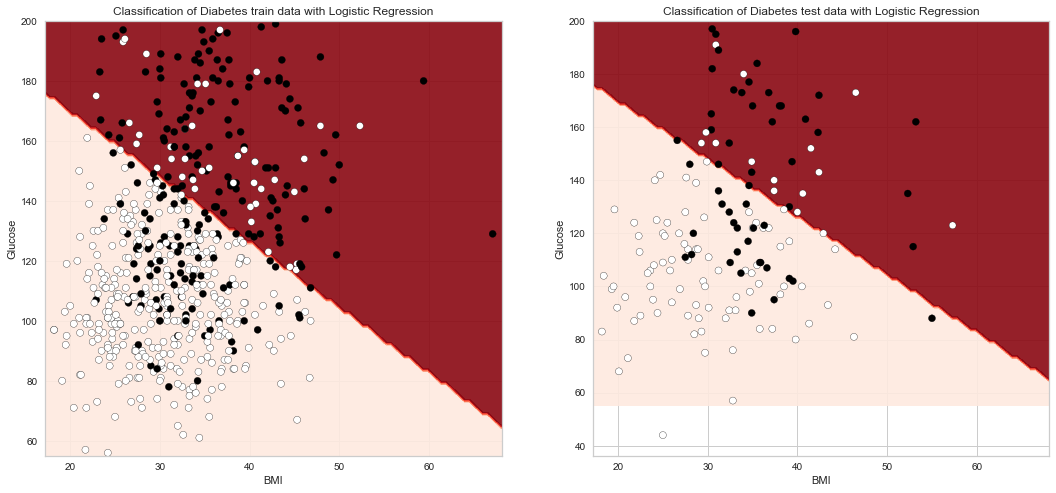

In [561]:
#plot the train and test data on the decision boundary to see how
#our model is good at classifying the true labels
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 8]

fig, ax = plt.subplots(1,2)

#left plot: plot the training data on the decisionboundary learned from training data
db = DecisionBoundaryDisplay.from_estimator(logreg, X_train, response_method="predict",
                                            xlabel="BMI", ylabel="Glucose", ax = ax[0],
                                            cmap="Reds", alpha=0.9)       
db.ax_.scatter(X_train.bmi, X_train.glucose, c=y_train.diabetes, edgecolor="black")
db.ax_.set_title('Classification of Diabetes train data with Logistic Regression')
#could not add legend labels here
#https://stackoverflow.com/questions/76359494/missing-markers-in-the-plot-legends-of-scikit-learn-examples

#right plot: plot the test data on the decisionboundary learned from training data
db = DecisionBoundaryDisplay.from_estimator(logreg, X_train, response_method="predict", 
                                            xlabel="BMI", ylabel="Glucose", ax = ax[1],
                                            cmap="Reds", alpha=0.9)      
db.ax_.scatter(X_test.bmi, X_test.glucose, c=y_test.diabetes, edgecolor="black")
db.ax_.set_title('Classification of Diabetes test data with Logistic Regression')

plt.show();

<br>

## A Simple Classification Algorithm: K-Nearest Neighbors (K-NN) Algorithm

-  Suppose we are given a training dataset $\mathcal{D} = \{(\mathbf{x}_{1}, y_{1}), (\mathbf{x}_{2}, y_{2}), \ldots, (\mathbf{x}_{n}, y_{n})\}$. 
At inference time, we receive a `new feature vector` $\mathbf{x}_{n+1}$ and we want to **predict its class label** $y_{n+1}$.
-   The K-NN first calculates the `distance` between the unseen feature vector $\mathbf{x}_{n+1}$ and each feature vector $\mathbf{x}_i$ available in training dataset $\mathcal{D}$ through a `distance function` such as:

\begin{equation}
d_i=d(\mathbf{x}_{n+1},\mathbf{x}_i),  \nonumber
\end{equation}

-   where $i=1, \ldots, n$.
-   Then among the set of distances $(d_1,\ldots,d_{n})$, the K-NN classifier identifies the $K$ points that are **closest** to $\mathbf{x}_{n+1}$:


\begin{equation}
\mathbb{N}_{K}(\mathbf{x}_{n+1})=\big\{\mathbf{x}_i: d(\mathbf{x}_{n+1},\mathbf{x}_i)  \leq d_{(K)}\big\},
\nonumber
\end{equation}

-   where $d_{(K)}$ is the $K$th smallest value of $(d_1,\ldots,d_{n})$.

<br>

![](img/knn.png)

-   In KNN classification, the `model predicted class label` of the future observation $\mathbf{x}_{n+1}$ is determined by the voting for the selected K-Nearest Neighbors, that is, the `majority class label` in the selected K-nearest neighbors is returned (`majority voting rule`).

## Illustration

-   Please watch the following:

<https://machinelearningknowledge.ai/wp-content/uploads/2021/07/Sklearn-KNN-Classifier.gif>

## Choosing a Distance Function

How do we select the training point $\mathbf{x}_i$ $(i=1,\ldots,n)$ that is the closest to the new point $\mathbf{x}_{n+1}$? 

### Minkowski Distance

-   The `Minkowski distance of order q`  between any two points $\mathbf{x}_{i}=(x_{i1},\ldots,x_{ij},\ldots, x_{id})^T$ and $\mathbf{x}_{i*}=(x_{i*1},\ldots,x_{i*j},\ldots,x_{i*d})^T$ in the **d-dimensional** feature space is defined as:


\begin{equation}
d(\mathbf{x}_{i}, \mathbf{x}_{i*}) := \left\| \mathbf{x}_{i}- \mathbf{x}_{i*}\right\|_{q}=\big(\sum_{j=1}^{d}| x_{ij}- x_{i*j}|^{q}\big)^{1/q},  \nonumber
\end{equation}

-   where $q=0,1,2$.

## Distance Metrics

-   When $q=0$, $d(\mathbf{x}_{i}, \mathbf{x}_{i*})=\sum_{j=1}^{d}I(x_{ij} \neq x_{i*j})$ is called `Hamming distance`.
-   When $q=1$, $d(\mathbf{x}_{i}, \mathbf{x}_{i*}) =\sum_{j=1}^{d}| x_{ij}- x_{i*j}|$ is called `Manhattan distance`.
-   When $q=2$, $d(\mathbf{x}_{i}, \mathbf{x}_{i*}) =\big(\sum_{j=1}^{d}| x_{ij}- x_{i*j}|^{2}\big)^{1/2}$ is called `Euclidean distance`.
-   In [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) class of scikit-learn's neighbors module, the default value is 2 (see below).

In [562]:
#Similarity between examples
#Let’s take 3 random points (three feature vectors) from the Diabetes dataset.

three_patients = X_train.sample(3, random_state=1773)
three_patients

,bmi,glucose
737,32.0,65
648,28.3,136
594,33.6,123


In [563]:
#take the first patient in the Xtest
query_point = list(X_test.iloc[0])
query_point

[33.2, 96.0]

In [564]:
# Euclidean distance using sklearn
from sklearn.metrics.pairwise import euclidean_distances

In [565]:
# Let's find a patient that's closest to the a query patient

dists = euclidean_distances(three_patients, [query_point])
dists

array([[31.02321711],
       [40.29900743],
       [27.0029628 ]])

In [566]:
# The query point is closest to
import numpy as np

print(
    "The query point %s is closest to the patient with index %d and the distance between them is: %0.4f"
    % (query_point, np.argmin(dists), dists[np.argmin(dists)])
)

The query point [33.2, 96.0] is closest to the patient with index 2 and the distance between them is: 27.0030


## Pre-processing
- Data with features that have **different scales** will bias the distance measures as those predictors with the largest values will contribute most to the distance between two samples.
- For that reason, most distance measures are sensitive to the scale of the features. 
- Euclidean distance is more sensitive to outliers due to the square term in its formula.
- For example, the Euclidean distance between patient648 and patient737 is larger compared to patient594 due to the larger difference in glucose.
- To **reduce the effect of magnitude of features on the distance metrics**, numerical features should be **pre-processed**.

* In addition to pre-processing numeric features, all categorical features must be one-hot encoded or ordinal-encoded using so that all categorical features are represented numerically. 

## Curse of dimensionality
- The KNN usually works well when the number of features is small. 
- The KNN method is very sensitive to noisy features since they cause variability in distance values. For that reason, removing irrelevant, noisy features often leads to significant improvement in KNN performance.

## K-Nearest Neighbors (K-NN) Algorithm Implementation

- K-NN is implemented in [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) in scikit-learn. The main parameters of the [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) function are:

   - `n_neighbors`: Number of neighbors to use for kneighbors queries. Default is 5.
   - `p=2`: Power parameter for the Minkowski metric.
   - `metric='minkowski'`: Metric to use for distance computation. Default is “minkowski”, which results in the standard Euclidean distance when p = 2.

Let's apply K-Nearest Neighbors to the Diabetes dataset using the Euclidean distance (or equiavalently, Minkowski with $p=2$) with a fixed value of 3 for K, but we will **optimize K later on**.

In [567]:
from sklearn.neighbors import KNeighborsClassifier

# Train a Nearest Neighbors Model
knn = KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=2)

In [568]:
#Lazy learning: Takes no time to fit
#This example is for illustration of how to use knn. 
#Next we will also scale the features
knn.fit(X_train, y_train.diabetes)

KNeighborsClassifier(n_neighbors=3)

In [569]:
#Class labels learned by the classifier
knn.classes_

array([0, 1])

In [570]:
y_test.diabetes.values

array([0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [571]:
#Return probability estimates
#print(knn.classes_)
#print(knn.predict_proba(X_test))

In [572]:
knn.predict(X_test)

array([0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0])

## Classification Accuracy

The simplest and most natural metric for classification algorithms is `accuracy` which compares model predicted labels to
the known labels and estimates the average number of correctly classified known labels in a set:

$$
\text{acc}(f) = \frac{1}{n}\sum_{i=1}^n \mathbb{I}\{\hat{f}(\textbf{x}_i) = y_i\},
$$
where $\mathbb{I}\{\cdot\}$ is an indicator function (equals 1 if its input is true and zero otherwise).

In [573]:
#score method returns accuracy by default in classification problems
print("Accuracy on train+val data: %.2f %%" % (knn.score(X_test, y_test)*100))

Accuracy on train+val data: 73.51 %


## How to choose n_neighbors?

- The primary `hyper-parameter` of the KNN algoritm is `n_neighbors (k)` which decides how many neighbours should vote during prediction.

In [574]:
#let's split our data set as train+val and test
from sklearn.model_selection import train_test_split

#split the data set as train_val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1773, stratify=y)

We will also use `strafied version of KFold splitter`, namely, [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) to generate cross-validation indices.

In [575]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

knn_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(metric='minkowski', p=2))

#defining parameter range
param_grid = {'kneighborsclassifier__n_neighbors': list(range(1, 30))}

#The folds are made by preserving the percentage of samples for each class.
kcv_index = StratifiedKFold(n_splits=5, shuffle=True, random_state=1773) 

grid_search = GridSearchCV(estimator = knn_pipe, param_grid = param_grid, 
                           scoring='accuracy', cv = kcv_index, #accuracy is the default metric
                           return_train_score=True) 

In [576]:
# fitting the model for grid search
grid_search.fit(X_train_val, y_train_val.diabetes)  #requires reshaping on y. did not understand why              

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1773, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5, 6,
                                                               7, 8, 9, 10, 11,
                                                               12, 13, 14, 15,
                                                               16, 17, 18, 19,
                                                               20, 21, 22, 23,
                                                               24, 25, 26, 27,
                                                               28, 29]},
             return_train_score=True, scoring='accuracy')

In [577]:
#you can investigate validation error in each 5 fold for a given K
#here test score = validation score
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.006241,0.001587,0.007632,0.000580,1,{'kneighborsclassifier__n_neighbors': 1},0.644628,0.700000,0.650000,0.691667,...,0.670592,0.022012,29,0.995833,0.989605,0.991684,0.987526,0.989605,0.990851,0.002817
1,0.005418,0.000068,0.007620,0.000207,2,{'kneighborsclassifier__n_neighbors': 2},0.685950,0.708333,0.691667,0.725000,...,0.707190,0.016296,27,0.845833,0.844075,0.866944,0.827443,0.858628,0.848585,0.013512
2,0.005317,0.000063,0.007583,0.000168,3,{'kneighborsclassifier__n_neighbors': 3},0.694215,0.683333,0.658333,0.725000,...,0.693843,0.022593,28,0.847917,0.852391,0.856549,0.841996,0.864865,0.852743,0.007750
3,0.005446,0.000179,0.007441,0.000057,4,{'kneighborsclassifier__n_neighbors': 4},0.710744,0.708333,0.700000,0.741667,...,0.728815,0.030704,25,0.810417,0.814969,0.806653,0.810811,0.817048,0.811979,0.003655
4,0.005418,0.000122,0.007555,0.000073,5,{'kneighborsclassifier__n_neighbors': 5},0.702479,0.691667,0.708333,0.775000,...,0.718829,0.029241,26,0.812500,0.812890,0.804574,0.794179,0.798337,0.804496,0.007469
5,0.005532,0.000401,0.008558,0.001178,6,{'kneighborsclassifier__n_neighbors': 6},0.719008,0.716667,0.716667,0.766667,...,0.738802,0.026300,22,0.793750,0.798337,0.787942,0.800416,0.798337,0.795756,0.004475
6,0.005738,0.000628,0.008429,0.000796,7,{'kneighborsclassifier__n_neighbors': 7},0.727273,0.716667,0.716667,0.758333,...,0.730455,0.015335,24,0.795833,0.819127,0.787942,0.783784,0.785863,0.794510,0.012967
7,0.005319,0.000043,0.008024,0.000563,8,{'kneighborsclassifier__n_neighbors': 8},0.752066,0.733333,0.725000,0.791667,...,0.758747,0.028273,7,0.785417,0.796258,0.785863,0.777547,0.775468,0.784110,0.007350
8,0.005426,0.000086,0.007559,0.000066,9,{'kneighborsclassifier__n_neighbors': 9},0.743802,0.700000,0.725000,0.791667,...,0.738760,0.030152,23,0.791667,0.808732,0.787942,0.785863,0.779626,0.790766,0.009795
9,0.005483,0.000175,0.007819,0.000390,10,{'kneighborsclassifier__n_neighbors': 10},0.743802,0.700000,0.750000,0.766667,...,0.745427,0.024452,21,0.785417,0.798337,0.790021,0.785863,0.775468,0.787021,0.007409


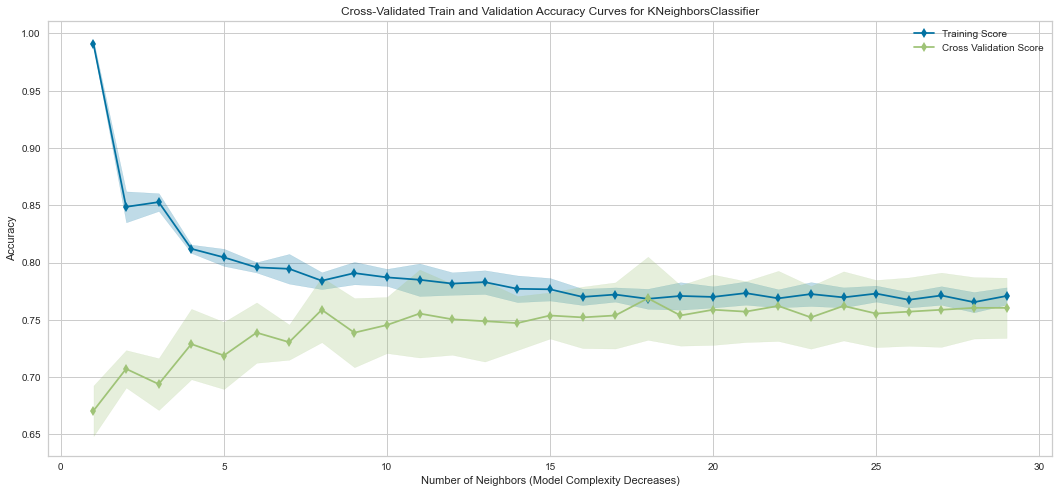

In [578]:
#visualize results
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 8]

from yellowbrick.model_selection import ValidationCurve


fig, ax = plt.subplots()

visualizer = ValidationCurve(estimator=knn_pipe, 
                             param_name="kneighborsclassifier__n_neighbors",  
                             param_range=list(range(1, 30)), 
                             cv=kcv_index, 
                             scoring="accuracy", 
                             ax=ax)

# Visualize
visualizer.fit(X_train_val, y_train_val.diabetes)
visualizer.ax.set_title("Cross-Validated Train and Validation Accuracy Curves for KNeighborsClassifier")
visualizer.ax.set_ylabel("Accuracy")
visualizer.ax.set_xlabel("Number of Neighbors (Model Complexity Decreases)")
visualizer.ax.legend().set_visible(True);
#visualizer.show(); #when on:does not return axis labels

A side question: Are we more likely to `overfit` with a low `n_neighbors` or a high `n_neighbors`?

In [579]:
print("Optimum K:", grid_search.best_params_)

Optimum K: {'kneighborsclassifier__n_neighbors': 18}


In [580]:
print("CV Validation Accuracy: %.2f %%" % (grid_search.best_score_*100))

CV Validation Accuracy: 76.88 %


In [581]:
grid_search.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=18))])

In [582]:
#Evaluate performance of best KNN on train+val
print("Accuracy on train+val data: %.2f %%" % (grid_search.best_estimator_.score(X_train_val, y_train_val)*100))

Accuracy on train+val data: 77.70 %


In [583]:
#Evaluate final performance of best KNN on test
print("Accuracy on test data: %.2f %%" % (grid_search.best_estimator_.score(X_test, y_test)*100))

Accuracy on test data: 72.85 %


Our algorithm's predictive accuracy on the test data is 72.85 %.

## Confusion Matrix and Accuracy

We can explicity display how the classifier performed on test data through `confusion matrix`. The confusion matrix involves:

$ $                  | Predicted negative $\hat y=0$  | Predicted positive $\hat y=1$
---------------------|--------------------------------|------------------------------
Negative class $y=0$ | True negative (TN)             | False positive (FP)           
Positive class $y=1$ | False negative (FN)            | True positive (TP)       


- `True Negative (TN):` The actual label and the predicted label are both 0.
- `False Negative (FN):` The actual label is 1, but, the predicted label is 0.
- `False Positive (FP):` The actual label is 0, but, the predicted label is 1.
- `True Positives (TP):` The actual label and the predicted label are both 1.

We can define accuracy as follows:
$$\text{accuracy} = \frac{\text{TN} + \text{TP}}{\text{TN} + \text{FN} + \text{FP} + \text{TP}}$$
This is the number of correction predictions divided by the total number of predictions.

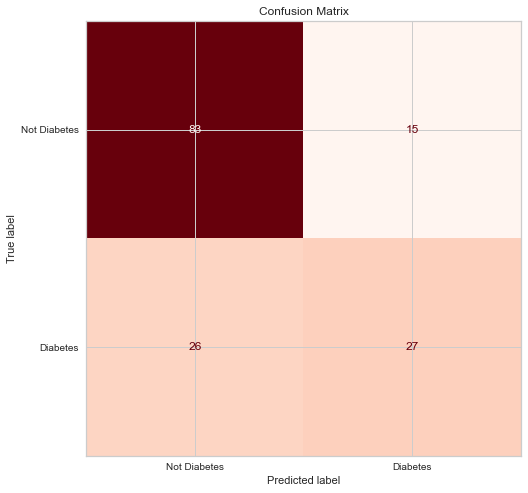

In [584]:
#display confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, 
                                           X_test, y_test, 
                                           display_labels=["Not Diabetes","Diabetes"], 
                                           cmap="Reds",
                                           colorbar=False)
                                           
cm.ax_.set_title("Confusion Matrix");

In [585]:
print("Accuracy %.4f" % ((83+27)/(83+26+15+27)))

Accuracy 0.7285


## Investigating Decision Boundaries for Inspecting Over-fitting & Under-fitting

What happens to decision boundary of KNN classifier when we play around with n_neighbors?

Are we more likely to `overfit` with a low `n_neighbors` or a high `n_neighbors`?

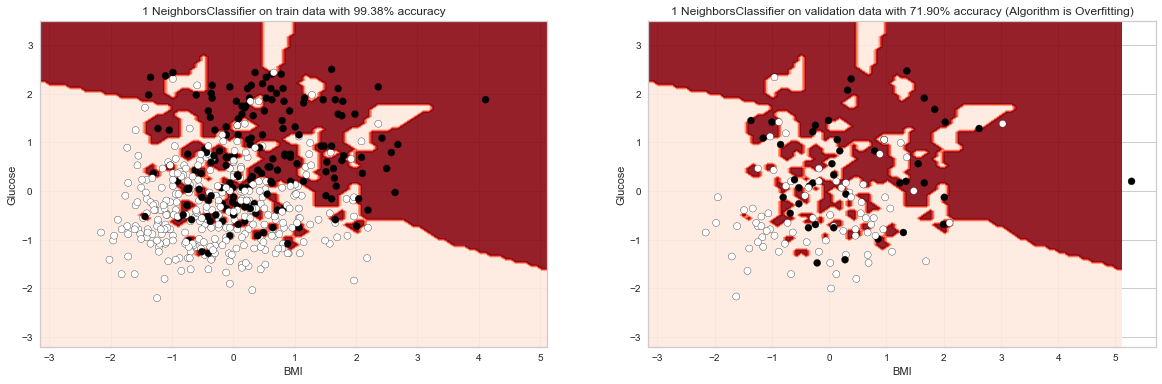

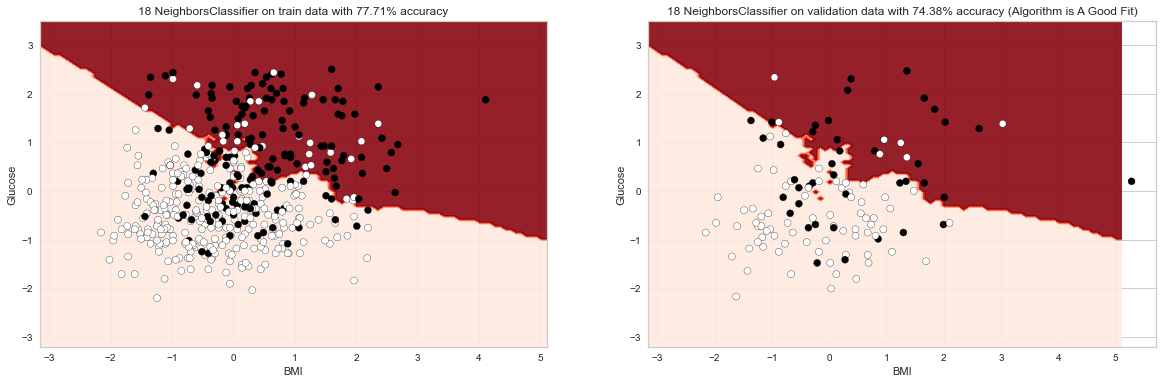

In [586]:
#let's do a quick search
from sklearn import set_config
set_config(transform_output="pandas")  

import pandas as pd 

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 6]

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

#split the data set as train_val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1773, stratify=y)

#split the data set as train and val
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.20, random_state = 1773, stratify=y_train_val)

kneighbor = [1, 18]

#i did not observe under-fitting in this data set
titles = ['Overfitting', 'A Good Fit']


for k in range(len(kneighbor)):
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    knn_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=kneighbor[k], metric='minkowski', p=2)) 
    
    knn_pipe.fit(X_train, y_train.diabetes)
    
    #get accuracy
    train_accuracy = knn_pipe.score(X_train, y_train)
    val_accuracy = knn_pipe.score(X_val, y_val)
    
    #get transformed matrices
    X_train_scaled = knn_pipe[0].fit_transform(X_train)
    X_val_scaled = knn_pipe[0].transform(X_val)

    #left plot:training data on decision boundary
    db = DecisionBoundaryDisplay.from_estimator(
    knn_pipe[1], X_train_scaled, response_method="predict", xlabel="BMI", ylabel="Glucose", ax = ax1, cmap="Reds", alpha=0.9) 
    
    db.ax_.scatter(X_train_scaled.bmi, X_train_scaled.glucose, c=y_train.diabetes, edgecolor="black")
    db.ax_.set_title('%.f NeighborsClassifier on train data with %.2f%% accuracy' % (kneighbor[k], 100*train_accuracy)) #, 
    
    #right plot:validation data on decision boundary (decisioun boundary learning is done over training data)
    db = DecisionBoundaryDisplay.from_estimator(
    knn_pipe[1], X_train_scaled, response_method="predict", xlabel="BMI", ylabel="Glucose", ax = ax2, cmap="Reds", alpha=0.9) 

    db.ax_.scatter(X_val_scaled.bmi, X_val_scaled.glucose, c=y_val.diabetes, edgecolor="black")
    db.ax_.set_title('%.f NeighborsClassifier on validation data with %.2f%% accuracy (Algorithm is %s)' % (kneighbor[k], 100*val_accuracy, titles[k])) 

    plt.show();

- When K = 1, the `decision boundary` is overly `flexible`. This
corresponds `over-fitting`.
- As 𝐾 grows, the method becomes less flexible and produces a `decision boundary` that is close to `linear`. This corresponds to `under-fitting`. (In this example, we do not have under-fitting)
- So, `low values` of K typically `over-fit` and `large values` often `under-fit`.

## References

- James, G., Witten, D., Hastie, T., Tibshirani, R., James, G., Witten, D., and Tibshirani, R. (2021). Statistical learning. An introduction to statistical learning: with applications in R. https://www.statlearning.com/.
- Müller, A. C., & Guido, S. (2016). Introduction to machine learning with Python: A guide for data scientists. O'Reilly Media, Inc.
- https://github.com/kuleshov/cornell-cs5785-2020-applied-ml/tree/main/notebooks
- https://bradleyboehmke.github.io/HOML/knn.html
- https://stats.stackexchange.com/questions/370531/knn-decision-boundary
- https://github.com/YBI-Foundation/Dataset/blob/main/Diabetes.csv
- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestCentroid.html

In [587]:
import session_info
session_info.show()